In [2]:
import pandas as pd
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

# Grade Analysis

In [3]:
grade_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
grade_df = grade_df[~grade_df['grade'].isnull()]
grade_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


# Inter-Rater Analysis

In [4]:
# TODO Discuss with Neil what to do with this mistake
# 105 duplicated accidentally between the two batches... in additional to the purposeful duplication.
skill_df = grade_df[grade_df['skill'] == 'Readability'][['participant_id', 'assignment_number', 'grade']]
group_df = skill_df[skill_df['participant_id'].isin([21, 22, 23, 24])].sort_values(by='participant_id')
group_df[group_df['assignment_number'] == 105]
# pivot = group_df.pivot(index='assignment_number', columns='participant_id', values='grade')

,participant_id,assignment_number,grade
4,21,105.0,A+
8,21,105.0,A+
4,22,105.0,A
8,22,105.0,A
4,23,105.0,B
8,23,105.0,C-
4,24,105.0,D+
8,24,105.0,B-


In [5]:
def calculate_fleiss_kappa(skill, participant_list):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'grade']]
    group_df = skill_df[skill_df['participant_id'].isin(participant_list)].sort_values(by='participant_id')
    pivot = group_df.pivot(index='assignment_number', columns='participant_id', values='grade')
    if any(pivot.isna().any(axis=1)):
        print('Missing Grade: ', pivot[pivot.isna().any(axis=1)])
        pivot.dropna(inplace=True)
  
    return fleiss_kappa(aggregate_raters(pivot)[0], 'fleiss')

In [8]:
results_df = None

for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
    for i in range(1, 28, 4):
        group = list(range(i, i + 4))
        group_str = str(group[0]) + '-' + str(group[-1])
        try:
            results_df = pd.concat([results_df, pd.DataFrame({
                                    'group': group_str,
                                    'skill': skill,
                                    'fliess_kappa': calculate_fleiss_kappa(skill, group)}, index=[0])])
        except ValueError:
            print('Error duplicate entries check data for: ', group_str)
        
        
results_df

Missing Grade:  participant_id      13  14  15 16
assignment_number                
306.0              NaN  A+  B+  A
Error duplicate entries check data for:  21-24
Error duplicate entries check data for:  21-24
Error duplicate entries check data for:  21-24
Missing Grade:  participant_id      9  10  11  12
assignment_number                
117.0              NaN  B  A+  A-
Error duplicate entries check data for:  21-24
Missing Grade:  participant_id      25   26   27   28
assignment_number                    
394.0              A++  A++  NaN  A++


,group,skill,fliess_kappa
0,1-4,Correctness,0.042673
0,5-8,Correctness,-0.024104
0,9-12,Correctness,0.003440
0,13-16,Correctness,0.041807
0,17-20,Correctness,0.113360
0,25-28,Correctness,0.046496
0,1-4,Readability,-0.002874
0,5-8,Readability,-0.070433
0,9-12,Readability,-0.069315
0,13-16,Readability,-0.057512


### Average Fliess Kappa
#### Skill

In [14]:
results_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.014940
1,Correctness,0.037279
2,Documentation,-0.010450
3,Readability,-0.022229


#### Group

In [15]:
results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

,group,fliess_kappa
0,1-4,0.009584
1,13-16,-0.000166
2,17-20,0.035506
3,25-28,0.066987
4,5-8,-0.044771
5,9-12,-0.037831


# Intra-Rater Relability

In [4]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [5]:
intra_rater_df = grade_df[grade_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'grade']]
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
12,358.0,Readability,15,1,A-
12,358.0,Correctness,15,1,B
12,358.0,Code Elegance,15,1,A-
12,358.0,Documentation,15,1,B-
0,160.0,Readability,24,1,A+
...,...,...,...,...,...
19,144.0,Documentation,1,1,A
12,358.0,Readability,14,1,A+
12,358.0,Correctness,14,1,A++
12,358.0,Code Elegance,14,1,A+


### Map replacement IDs to original IDs

In [6]:
intra_rater_df['assignment_number'] = intra_rater_df['assignment_number'].apply(lambda x: x if x not in DUPLICATE_MAP.keys() else DUPLICATE_MAP[x])
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
12,358.0,Readability,15,1,A-
12,358.0,Correctness,15,1,B
12,358.0,Code Elegance,15,1,A-
12,358.0,Documentation,15,1,B-
0,160.0,Readability,24,1,A+
...,...,...,...,...,...
19,144.0,Documentation,1,1,A
12,358.0,Readability,14,1,A+
12,358.0,Correctness,14,1,A++
12,358.0,Code Elegance,14,1,A+


### Check if the graders graded the same for both batch 1 and batch 2

In [54]:
match_df = intra_rater_df.pivot(index=['assignment_number', 'skill', 'participant_id'], columns='batch', values='grade').reset_index()
match_df['match'] = match_df[1] == match_df[2]
match_df.columns = ['assignment_number', 'skill', 'participant_id', 'grade_1', 'grade_2', 'match']
match_df

,assignment_number,skill,participant_id,grade_1,grade_2,match
0,97.0,Code Elegance,9,A-,B+,False
1,97.0,Code Elegance,10,F,F,True
2,97.0,Code Elegance,11,A-,A+,False
3,97.0,Code Elegance,12,A-,B,False
4,97.0,Correctness,9,B+,A,False
...,...,...,...,...,...,...
107,559.0,Documentation,8,A,A,True
108,559.0,Readability,5,A-,B+,False
109,559.0,Readability,6,A-,A++,False
110,559.0,Readability,7,A+,A+,True


### Count the matches per skill

<Axes: xlabel='skill', ylabel='grade_1'>

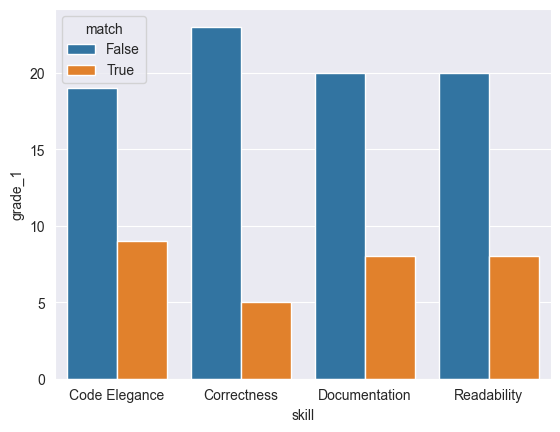

In [55]:
sns.barplot(match_df.groupby(['skill', 'match']).count(), x='skill', y='grade_1', hue='match')

### Count of match per grade

<Axes: xlabel='grade_1', ylabel='grade_2'>

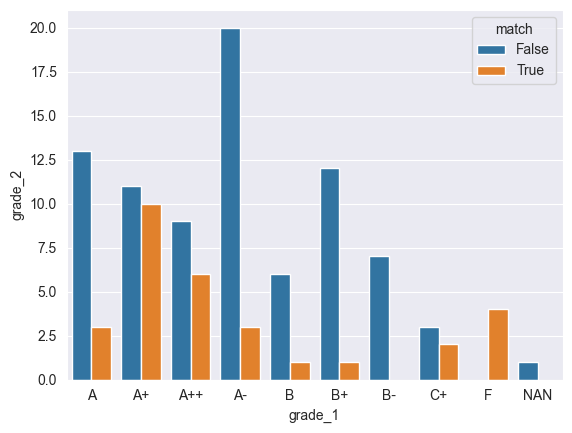

In [56]:
sns.barplot(match_df.groupby(['grade_1', 'match']).count(), x='grade_1', y='grade_2', hue='match')

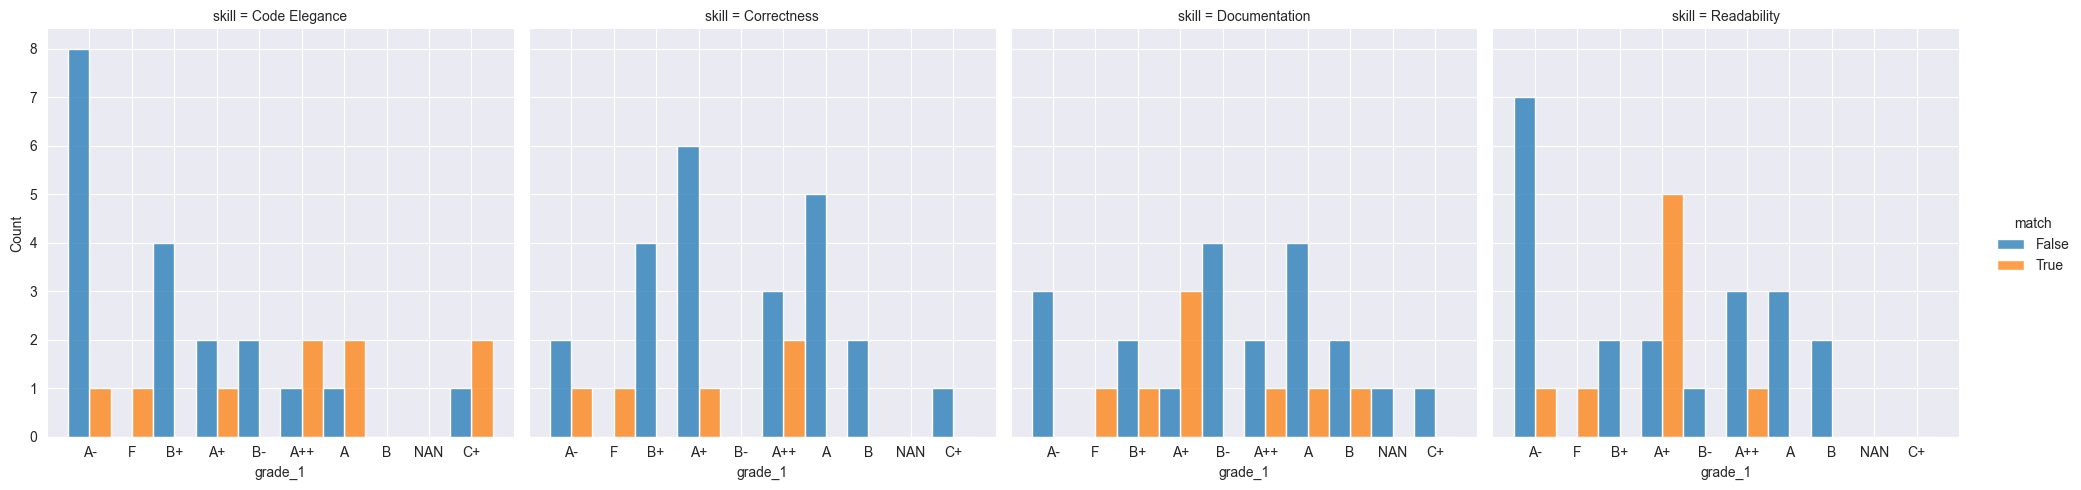

In [68]:
sns.displot(match_df, x='grade_1', col='skill', hue='match', multiple='dodge')

# Summary of Grades per skill

In [24]:
grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})
grade_count_df

,skill,grade,count
0,Code Elegance,A,191
1,Code Elegance,A+,199
2,Code Elegance,A++,148
3,Code Elegance,A-,132
4,Code Elegance,B,128
5,Code Elegance,B+,117
6,Code Elegance,B-,73
7,Code Elegance,C,22
8,Code Elegance,C+,53
9,Code Elegance,C-,13


<Axes: xlabel='grade', ylabel='count'>

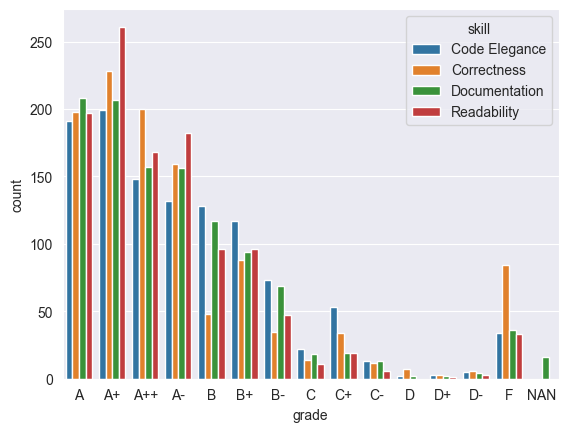

In [25]:
sns.barplot(x='grade', y='count', data=grade_count_df, hue='skill')

# Feedback Analysis

In [82]:
feedback_df = grade_df[['participant_id', 'assignment_number', 'skill', 'comments']]
feedback_df

,participant_id,assignment_number,skill,comments
0,15,18.0,Readability,The code use meaningful identifier names and a...
1,15,620.0,Readability,Code is well organized into logical classes an...
2,15,466.0,Readability,"The code is well-organized, consistently inden..."
3,15,591.0,Readability,The code is well organized and readable. Inden...
4,15,587.0,Readability,The code is well organized and readable. Inden...
...,...,...,...,...
15,14,58.0,Documentation,NaN
16,14,353.0,Documentation,NaN
17,14,422.0,Documentation,NaN
18,14,480.0,Documentation,NaN


### Count of submissions with no feedback

In [92]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,participant_id,assignment_number,comments,missing
0,Code Elegance,1120,1120,677,443
1,Correctness,1116,1116,714,402
2,Documentation,1118,1118,710,408
3,Readability,1120,1120,631,489


<Axes: xlabel='skill', ylabel='missing'>

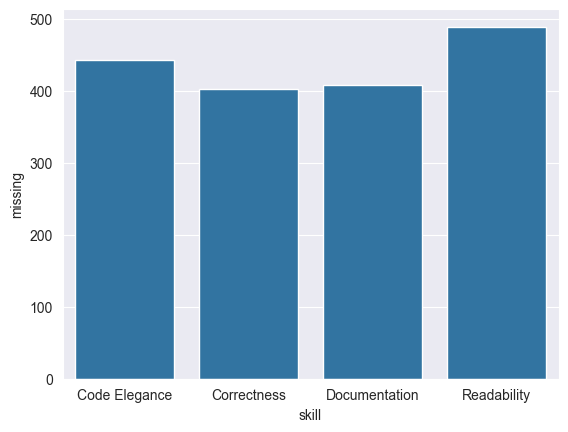

In [93]:
sns.barplot(count_df, x='skill', y='missing')

### All unique feedback

In [97]:
feedback_df[['skill', 'comments']]

,skill,comments
0,Readability,The code use meaningful identifier names and a...
1,Readability,Code is well organized into logical classes an...
2,Readability,"The code is well-organized, consistently inden..."
3,Readability,The code is well organized and readable. Inden...
4,Readability,The code is well organized and readable. Inden...
...,...,...
15,Documentation,NaN
16,Documentation,NaN
17,Documentation,NaN
18,Documentation,NaN
